<a href="https://colab.research.google.com/github/henriqueburis/VOXAR_temp/blob/main/VOXAR_lab_alt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Etapa 2 do desafio

In [1]:
!git clone https://github.com/Sense-X/Co-DETR.git

Cloning into 'Co-DETR'...
remote: Enumerating objects: 1838, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 1838 (delta 134), reused 223 (delta 127), pack-reused 1602
Receiving objects: 100% (1838/1838), 18.35 MiB | 28.95 MiB/s, done.
Resolving deltas: 100% (729/729), done.


In [ ]:
!pip install '/content/Co-DETR'

In [9]:
import torch
import cv2
import numpy as np
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
from google.colab.patches import cv2_imshow

In [10]:
model = fasterrcnn_resnet50_fpn(pretrained=True)  # Pretrained=False para carregar seu próprio peso

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 247MB/s]


In [ ]:
model.eval()

In [12]:
!wget 'https://s2.glbimg.com/1XR-8dIVljsAe25R1e4SuFRWTzNg1kkBw2TeAHWSakxIoz-HdGixxa_8qOZvMp3w/s.glbimg.com/jo/g1/f/original/2012/08/30/nova_imagem_1.jpg'

--2023-10-09 17:36:31--  https://s2.glbimg.com/1XR-8dIVljsAe25R1e4SuFRWTzNg1kkBw2TeAHWSakxIoz-HdGixxa_8qOZvMp3w/s.glbimg.com/jo/g1/f/original/2012/08/30/nova_imagem_1.jpg
Resolving s2.glbimg.com (s2.glbimg.com)... 186.192.91.9
Connecting to s2.glbimg.com (s2.glbimg.com)|186.192.91.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97421 (95K) [image/jpeg]
Saving to: ‘nova_imagem_1.jpg’

nova_imagem_1.jpg   100%[===================>]  95.14K   294KB/s    in 0.3s    

2023-10-09 17:36:32 (294 KB/s) - ‘nova_imagem_1.jpg’ saved [97421/97421]



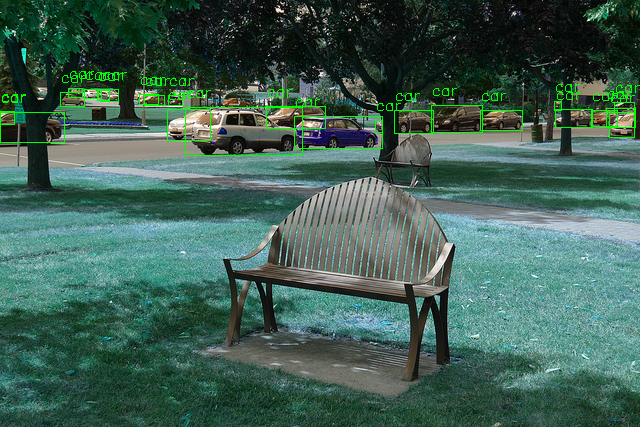

In [ ]:
# Carregue uma imagem de exemplo (substitua pelo caminho do seu arquivo de imagem)
image = Image.open('/content/Co-DETR/demo/demo.jpg')

# Converta a imagem em um tensor
image_tensor = F.to_tensor(image).unsqueeze(0)  # Adicione uma dimensão para o lote (batch)

# Faça uma detecção na imagem
with torch.no_grad():
    predictions = model(image_tensor)

#print(predictions[0]['labels'])
chosen_class_id = 3

class_names = {
    1: 'Classe 1',
    2: 'Classe 2',
    3: 'car',
    # Adicione mais mapeamentos conforme necessário
}

# Converta as previsões em uma imagem com caixas delimitadoras desenhadas
image_np = np.array(image)  # Converta a imagem PIL para NumPy
image_copy = image_np.copy()

# Loop pelas caixas delimitadoras detectadas
for score, box, labels in zip(predictions[0]['scores'], predictions[0]['boxes'], predictions[0]['labels']):
    #print(labels)
    if(labels == chosen_class_id):
      # Desenhe uma caixa delimitadora apenas para previsões com confiança maior que um limiar
      if score > 0.5:  # Você pode ajustar esse limiar conforme necessário
          x1, y1, x2, y2 = map(int, box.tolist())
          cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 1)  # Desenha uma caixa verde
          #print(int(labels.cpu().numpy()))
          class_name = class_names.get(int(labels.cpu().numpy()), 'Desconhecido')  # Obtém o nome da classe ou "Desconhecido" se não houver mapeamento
          cv2.putText(image_copy, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)  # Adicione o nome da classe acima da caixa

# Mostre a imagem resultante com as caixas delimitadoras
#cv2.imshow('Detecções Faster R-CNN', image_copy)
cv2_imshow(image_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [13]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2

# Carregue uma imagem de exemplo
image = Image.open('/content/Co-DETR/demo/demo.jpg')

# Transforme a imagem para o formato esperado pelo modelo
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalização com base nas médias e desvios padrão do ImageNet
])
image = transform(image).unsqueeze(0)  # Adicione uma dimensão para o lote (batch)

# Carregue um modelo de segmentação semântica pré-treinado, por exemplo, uma U-Net
model_ = models.segmentation.deeplabv3_resnet101(pretrained=True)

model_.eval()
# Faça a segmentação na imagem
with torch.no_grad():
    output = model_(image)['out']

# Converta a saída em uma máscara de segmentação
mask = output.argmax(1).cpu().numpy()[0]

print(mask.shape)

# Defina cores para cada classe (classe 0, classe 1, classe 2, etc.)
class_colors = [
    (0, 0, 0),   # Cor da classe 0
    (255, 0, 0), # Cor da classe 1
    (0, 255, 0), # Cor da classe 2
    # Adicione mais cores conforme necessário
]

single_color = (0, 0, 255)

# Crie uma imagem colorida com base na máscara de segmentação e cores das classes
colored_mask = np.zeros_like(image[0].cpu().numpy())
print(colored_mask.shape)


for class_id, color in enumerate(class_colors):
    #colored_mask[mask == class_id] = color
    colored_mask[mask] = single_color

# Exiba a máscara de segmentação colorida
cv2.imshow('Segmentação Semântica', colored_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


(427, 640)
(3, 427, 640)


ValueError: ignored

tensor([ 1,  1,  1,  3,  3,  3,  1,  3,  3,  1,  3,  1,  1,  1,  1,  1,  1,  1,
         1,  1, 10,  1,  1,  1,  3, 10,  1, 33, 28,  1,  3,  3, 10, 10,  1,  1,
         3,  1,  3,  3, 33,  1,  3,  1,  1,  3,  8, 27, 15,  8, 64,  1,  1, 14,
         8, 10,  3,  1,  3,  1, 13,  1,  8,  6])


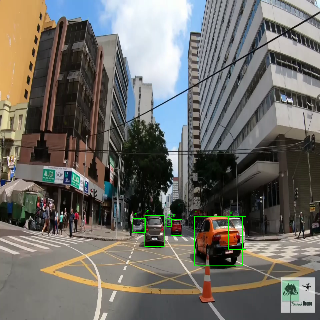

tensor([ 1,  1,  1,  3,  3,  3,  1,  3,  3,  1,  3,  1,  1,  1,  1,  1,  1,  1,
         1,  1, 10,  1,  1,  1,  3, 10,  1, 33, 28,  1, 10,  3,  3, 10,  1,  1,
         1,  3,  3,  3, 33,  1,  3,  1,  1,  3,  8, 27, 15,  8, 64,  1,  1, 14,
         8, 10,  1,  3,  3,  1, 13,  1,  6,  8])


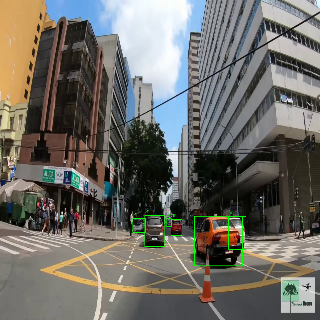

tensor([ 1,  1,  1,  3,  3,  3,  3,  3,  1,  3,  1,  1,  1,  1,  1,  1,  1,  1,
        10,  1,  1, 28,  1,  3,  1,  1,  1,  1,  3,  3,  3,  1,  1,  1, 33, 33,
         1,  3,  3,  1,  1,  1,  3,  1,  1, 33, 28, 10, 10,  1,  1,  1,  3,  1,
         8,  3,  1, 10, 27,  3,  1,  3,  1,  8,  8, 14,  1, 27,  1])


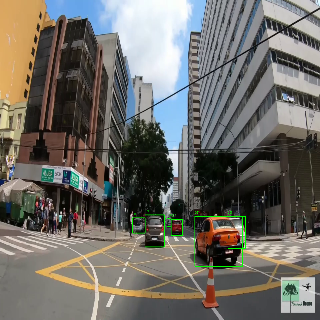

tensor([ 1,  1,  1,  3,  3,  3,  3,  1,  1,  1,  1,  3,  1,  3,  1,  1,  1,  1,
         1,  1, 10,  3,  1,  1,  3, 28,  1,  3,  1,  1,  3,  3,  1, 10,  3,  3,
         1, 33,  3,  1,  1, 27, 28,  1,  3,  3, 10,  1, 64, 14,  1,  1,  1,  3,
         1,  1,  8,  1,  1, 33,  3,  8, 10,  1, 10,  1,  1,  3,  3,  8, 28, 31,
        27,  3,  3])


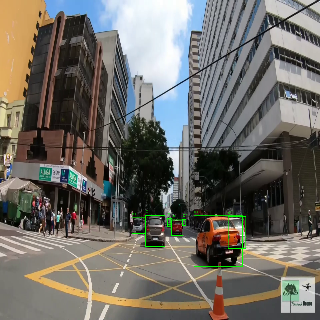

KeyboardInterrupt: ignored

In [15]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import cv2
import numpy as np

# Carregue o modelo e os pesos (como mencionado anteriormente)

# Abra o vídeo
video_path = '/content/drive/MyDrive/curitiba.mp4'  # Substitua pelo caminho do seu vídeo
cap = cv2.VideoCapture(video_path)

# Verifique se o vídeo foi aberto corretamente
if not cap.isOpened():
    print("Erro ao abrir o vídeo.")
    exit()

class_names = {
    1: 'Classe 1',
    2: 'Classe 2',
    3: 'car',
    # Adicione mais mapeamentos conforme necessário
}

# Loop pelos quadros do vídeo
while True:
    # Leia o próximo quadro
    ret, frame = cap.read()
    if not ret:
        break

    # Converta o quadro em um tensor
    frame_tensor = F.to_tensor(frame).unsqueeze(0)  # Adicione uma dimensão para o lote (batch)

    # Faça uma detecção no quadro
    with torch.no_grad():
        predictions = model(frame_tensor)

    # Converta as previsões em uma imagem com caixas delimitadoras desenhadas
    image_copy = frame.copy()

    print(predictions[0]['labels'])
    chosen_class_id = 3

    # Contagem de ocorrências do elemento 3
    count_car = np.count_nonzero(predictions[0]['labels'] == chosen_class_id)

    # Loop pelas caixas delimitadoras detectadas
    for score, box, labels in zip(predictions[0]['scores'], predictions[0]['boxes'], predictions[0]['labels']):

      if(labels == chosen_class_id):
        # Desenhe uma caixa delimitadora apenas para previsões com confiança maior que um limiar
        if score > 0.5:  # Você pode ajustar esse limiar conforme necessário
            x1, y1, x2, y2 = map(int, box.tolist())
            cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Desenha uma caixa verde
            class_name = class_names.get(int(labels.cpu().numpy()), 'Desconhecido')  # Obtém o nome da classe ou "Desconhecido" se não houver mapeamento
            cv2.putText(image_copy, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)  # Adicione

    # Mostre o quadro com as caixas delimitadoras
    #cv2.imshow('Detecções Faster R-CNN', image_copy)

    resized_frame = cv2.resize(image_copy, (320, 320))
    cv2_imshow(resized_frame)
    #break

    # Verifique se o usuário pressionou a tecla 'q' para sair
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

print(f"Total de carros detectados: {count_car}")

# Libere os recursos
cap.release()
cv2.destroyAllWindows()

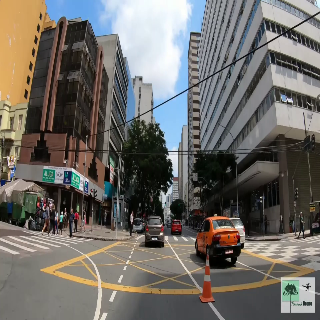

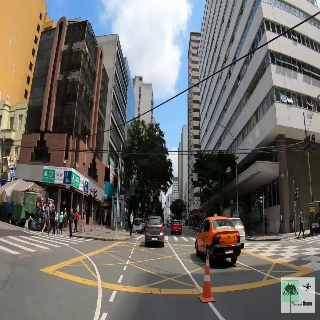

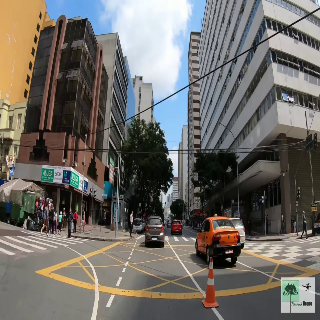

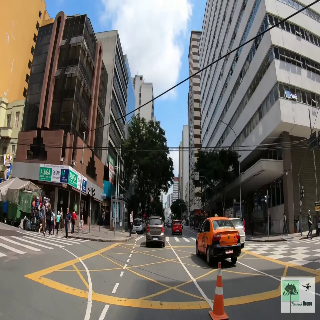

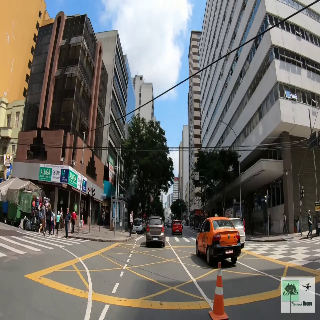

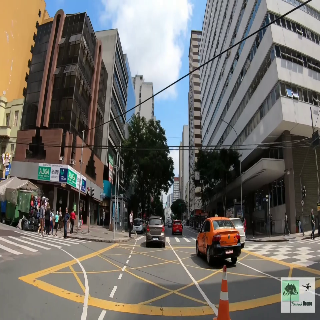

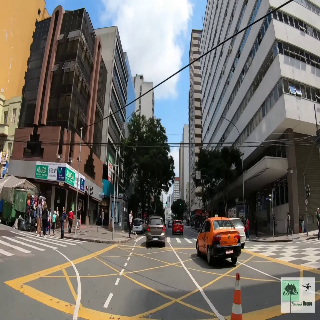

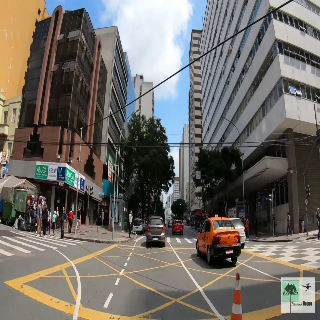

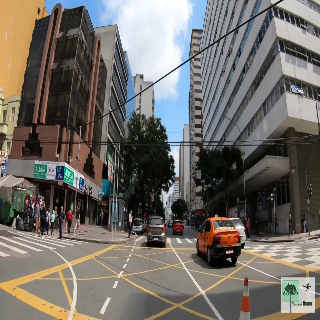

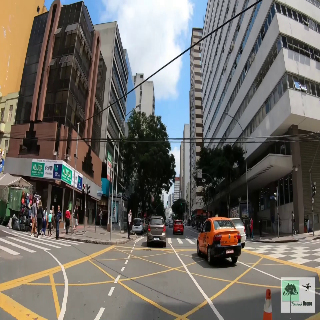

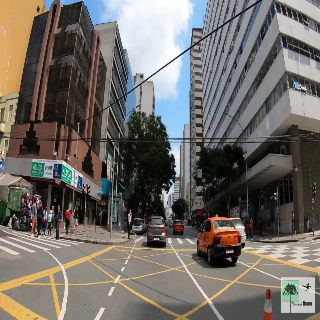

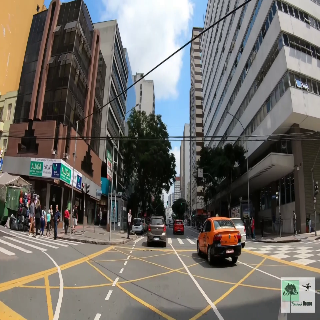

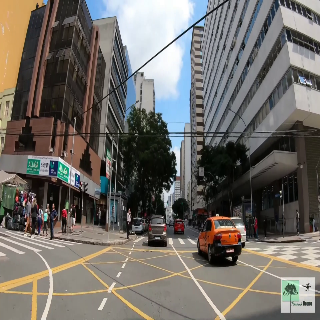

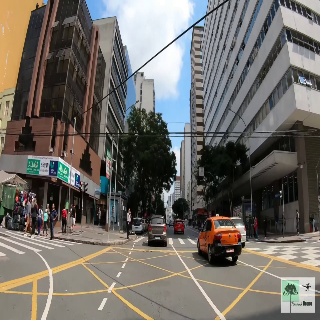

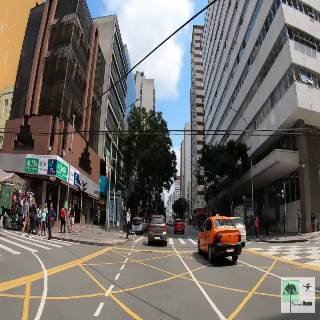

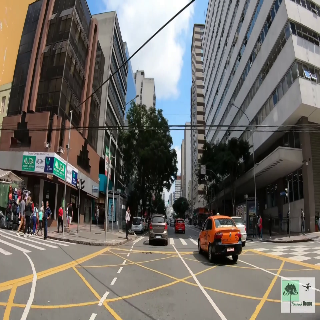

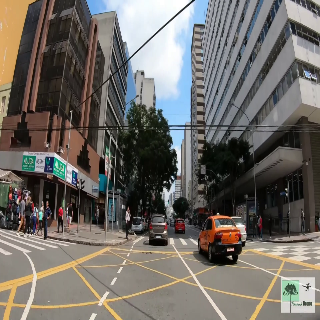

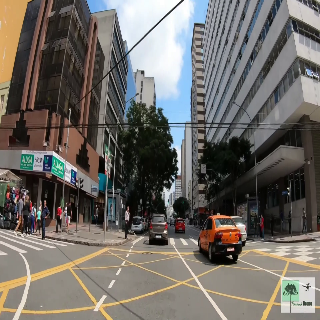

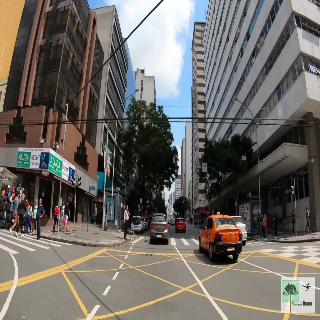

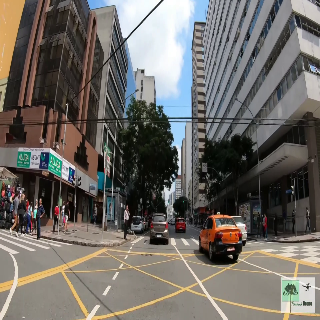

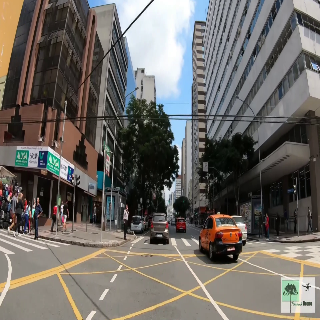

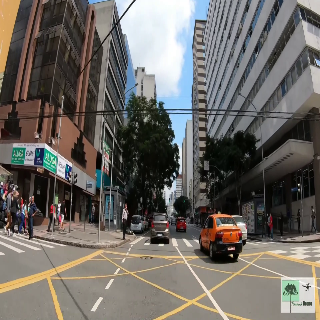

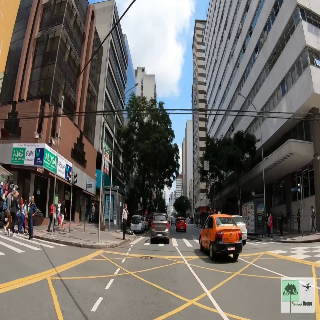

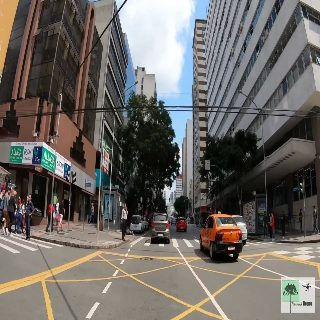

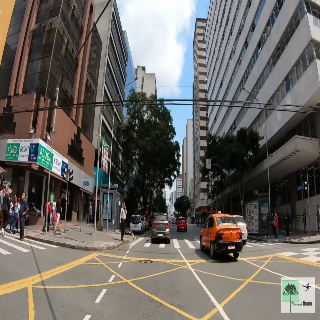

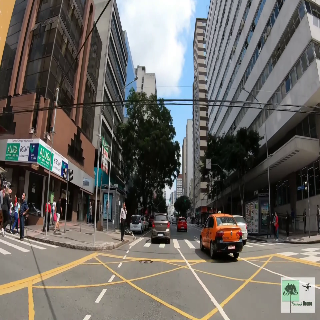

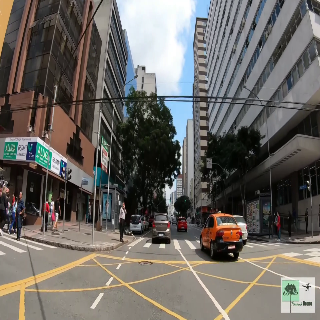

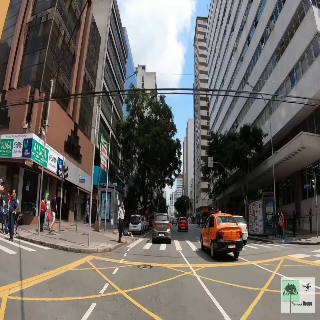

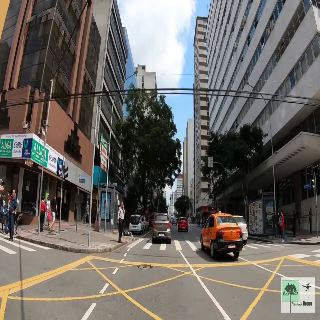

KeyboardInterrupt: ignored

In [7]:
!pip install opencv-python
import cv2
from google.colab.patches import cv2_imshow


# Carregue o vídeo (substitua 'seu_video.mp4' pelo caminho do seu vídeo)
video_path = '/content/drive/MyDrive/curitiba.mp4'
cap = cv2.VideoCapture(video_path)

while True:
    ret, frame = cap.read()


    if not ret:
        break

    resized_frame = cv2.resize(frame, (320, 320))

    cv2_imshow(resized_frame)

    # Aguarde um curto período de tempo entre os quadros para manter a taxa de quadros
    cv2.waitKey(1)

# Libere o vídeo após a conclusão
cap.release()
cv2.destroyAllWindows()


#Etapa 2 final Sam para segmentação ultralytics

In [ ]:
!git clone https://github.com/ultralytics/ultralytics

fatal: destination path 'ultralytics' already exists and is not an empty directory.


In [ ]:
!cd ultralytics
!pip install -e .

Obtaining file:///content
ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
!mkdir data
!mkdir models
#!wget -c -P /content/models/ https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
!wget -c -P /content/models/ https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8x

--2023-10-09 14:17:22--  https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8x
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-10-09 14:17:22 ERROR 404: Not Found.



In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
from functools import reduce

from ultralytics import SAM
from ultralytics.models.sam import Predictor as SAMPredictor


ImportError: ignored

In [ ]:
# Load a model
model_sam = SAM('sam_b.pt')

# Display model information (optional)
model_sam.info()

Model summary: 238 layers, 93735472 parameters, 93735472 gradients


(238, 93735472, 93735472, 0.0)

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import cv2
import numpy as np

# Carregue o modelo e os pesos (como mencionado anteriormente)

# Abra o vídeo
video_path = '/content/drive/MyDrive/curitiba.mp4'  # Substitua pelo caminho do seu vídeo
cap = cv2.VideoCapture(video_path)

# Verifique se o vídeo foi aberto corretamente
if not cap.isOpened():
    print("Erro ao abrir o vídeo.")
    exit()

# Loop pelos quadros do vídeo
while True:
    # Leia o próximo quadro
    ret, frame = cap.read()
    if not ret:
        break

    # Converta o quadro em um tensor
    frame_tensor = F.to_tensor(frame).unsqueeze(0)  # Adicione uma dimensão para o lote (batch)

    # Faça uma detecção no quadro
    with torch.no_grad():
        predictions = model(frame_tensor)

    # Converta as previsões em uma imagem com caixas delimitadoras desenhadas
    image_copy = frame.copy()

    print(predictions[0]['labels'])
    chosen_class_id = 3

    # Contagem de ocorrências do elemento 3
    count_car = np.count_nonzero(predictions[0]['labels'] == chosen_class_id)

    # Loop pelas caixas delimitadoras detectadas
    for score, box, labels in zip(predictions[0]['scores'], predictions[0]['boxes'], predictions[0]['labels']):

      if(labels == chosen_class_id):
        print(box.numpy())
        res = model_sam(image_copy, bboxes=box.numpy())
        print(res)

        # Desenhe uma caixa delimitadora apenas para previsões com confiança maior que um limiar
        if score > 0.5:  # Você pode ajustar esse limiar conforme necessário
            x1, y1, x2, y2 = map(int, box.tolist())
            cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Desenha uma caixa verde

    # Mostre o quadro com as caixas delimitadoras
    #cv2.imshow('Detecções Faster R-CNN', image_copy)
    cv2_imshow(image_copy)
    break

    # Verifique se o usuário pressionou a tecla 'q' para sair
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

print(f"Total de carros detectados: {count_car}")

# Libere os recursos
cap.release()
cv2.destroyAllWindows()

tensor([ 1,  1,  1,  3,  3,  3,  1,  3,  3,  1,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1, 10,  1,  1,  1,  3, 10,  1, 33, 28,  1,  3,  3, 10, 10,  1,  1,  3,  1,  3,  3, 33,  1,  3,  1,  1,  3,  8, 27, 15,  8, 64,  1,  1, 14,  8, 10,  3,  1,  3,  1, 13,  1,  8,  6])
[     1371.2      731.55      1475.5      841.75]


0: 1024x1024 30151.9ms
Speed: 14.8ms preprocess, 30151.9ms inference, 22.4ms postprocess per image at shape (1, 3, 1024, 1024)


AttributeError: ignored

# outros teste de projeto

In [17]:
!pip install openmim
!mim install mmengine
#!mim install "mmcv>=2.0.0,<2.1.0"
!pip install mmcv-full==1.3.17 -f https://download.openmmlab.com/mmcv/dist/cpu/torch1.8.0/index.html
#!mim install mmcv==1.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 28.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.1/953.1 kB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.5/437.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 27.2 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cpu/torch1.8.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.2/390.2 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mmcv-full: filename=mmcv_full-1.3.17-cp310-cp310-linux_x86_64.whl size=73531533 sha256=041b624f60cb8a72935500ce02765948a35399e3cdd0d610a6fa939102863c2f
  Stored in directory: /root/.cache/pip/wheels/eb/fd/cb/ce9bea3ac1f205e8d49e0f1907fb94ee9e051324ab88e844dd
Successfully built mmcv-full


In [18]:
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -e .

Cloning into 'mmdetection'...
remote: Enumerating objects: 37502, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 37502 (delta 28), reused 67 (delta 23), pack-reused 37399
Receiving objects: 100% (37502/37502), 62.97 MiB | 23.42 MiB/s, done.
Resolving deltas: 100% (25851/25851), done.
/content/mmdetection
Obtaining file:///content/mmdetection
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmdet


In [ ]:
# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

Cloning into 'mmdetection'...
remote: Enumerating objects: 37450, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 37450 (delta 16), reused 44 (delta 13), pack-reused 37387
Receiving objects: 100% (37450/37450), 62.92 MiB | 23.48 MiB/s, done.
Resolving deltas: 100% (25835/25835), done.
/content/mmdetection
Obtaining file:///content/mmdetection
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmdet


In [19]:
import mmdet
print(mmdet.__version__)
# Example output: 3.0.0, or an another version.

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


AssertionError: ignored

In [ ]:
#!pip install mmcv-full
!pip install mmcv-full==1.7.1 -f https://download.openmmlab.com/mmcv/dist/cpu/torch2.0.1/index.html

In [20]:
!wget 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

--2023-10-09 18:10:25--  https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 8.48.85.208, 8.48.85.213, 8.48.85.212, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|8.48.85.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

faster_rcnn_r50_fpn 100%[===================>] 159.54M  10.2MB/s    in 16s     

2023-10-09 18:10:41 (10.1 MB/s) - ‘faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [21]:
import mmcv
from mmdet.apis import init_detector, inference_detector

config_file = '/content/mmdetection/configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py'
checkpoint_file = '/content/mmdetection/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
model = init_detector(config_file, checkpoint_file, device='cpu')  # or device='cuda:0'
#result = inference_detector(model, '/content/mmdetection/nova_imagem_1.jpg')

AssertionError: ignored

In [22]:
import torch
import cv2
import numpy as np

In [23]:

out = '/content/out'
video = '/content/curitiba.mp4'

chosen_class_id = 2 # Defina o ID da classe do objeto desejado apos olha os pessos do arquivo (por exemplo, carro)

checkpoint = torch.load(checkpoint_file)
print(checkpoint['meta']) # restorna todas informaçoes armazenado dentro do modelo salvo, para então pode escolher a classe
print(checkpoint['meta']['CLASSES'])
#('person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush')
print(checkpoint['meta']['CLASSES'][chosen_class_id]) ## Classe carro

video_reader = mmcv.VideoReader(video)
video_writer = None
if out:
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  video_writer = cv2.VideoWriter(
      out, fourcc, video_reader.fps,
       (video_reader.width, video_reader.height))


#for frame in mmcv.track_iter_progress(video_reader):
  #result = inference_detector(model, frame)

cap = cv2.VideoCapture(video)

# Verifique se o vídeo foi aberto corretamente
if not cap.isOpened():
    print("Erro ao abrir o vídeo.")
    exit()

# Loop pelos quadros do vídeo
while True:
    # Leia o próximo quadro
    ret, frame = cap.read()
    if not ret:
        break

    result = inference_detector(model, frame)

    # Acesse o objeto InstanceData
    instance_data = result.pred_instances

    # Acesse a propriedade labels
    labels = instance_data.labels
    scores_ = instance_data.scores
    boxes = instance_data.bboxes


    # Converta as previsões em uma imagem com caixas delimitadoras desenhadas
    image_copy = frame.copy()

    print(labels)
    print(scores_)
    print(boxes)
    chosen_class_id = 3

    # Loop pelas caixas delimitadoras detectadas
    for score, box, labels in zip(scores_, boxes, labels):

      #if(labels == chosen_class_id):
        # Desenhe uma caixa delimitadora apenas para previsões com confiança maior que um limiar
        if score > 0.1:  # Você pode ajustar esse limiar conforme necessário
            x1, y1, x2, y2 = map(int, box.tolist())
            cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Desenha uma caixa verde

    # Mostre o quadro com as caixas delimitadoras
    #cv2.imshow('Detecções Faster R-CNN', image_copy)
    cv2_imshow(image_copy)
    break

    # Verifique se o usuário pressionou a tecla 'q' para sair
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libere os recursos
cap.release()
cv2.destroyAllWindows()

NameError: ignored

In [ ]:
 # Substitua 'caminho_para_seu_video.mp4' pelo caminho do seu vídeo
video_reader = mmcv.VideoReader('caminho_para_seu_video.mp4')

In [ ]:
for frame in mmcv.track_iter_progress(video_reader):
    print(frame)
    # Faça algo com cada quadro, como rastreamento de objetos
    # Exemplo: detecção e rastreamento de objetos em cada quadro
   # detections = detect_objects(frame)  # Implemente sua função de detecção de objetos
  #  tracked_objects = track_objects(detections)  # Implemente sua função de rastreamento de objetos
    # Continue o processamento

AttributeError: ignored

In [ ]:
from mmdet.apis import init_detector, inference_detector

config_file = 'configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
# download the checkpoint from model zoo and put it in `checkpoints/`
# url: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
checkpoint_file = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
device = 'cuda:0'
# init a detector
model = init_detector(config_file, checkpoint_file, device=device)
# inference the demo image
inference_detector(model, 'demo/demo.jpg')